<a href="https://colab.research.google.com/github/SergeyB81/Portfolio-DS/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5%20CG/Finteh-86-89/fintech_testcase_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Во вложении, файл, нужно сделать следующее

-сделать модель, предсказывающую вероятность дефолта (таргет fpd5_flg),
в качестве предикторов можно использовать все что есть в файле
(не обязательно абсолютно все), кроме dt (это дата выдачи кредита).
Можно делать в чем угодно. Преобразовывать переменные можно как угодно.
В качестве инструмента можно выбрать обычную логистическую регрессию.

-на выходе должен быть тот же самый файл, но напротив каждого наблюдения
должна быть проставлена вероятность дефолта по построенной модели

-нужно сделать мини-отчет по модели в Excel или Word (или Jupiter Notebook),
показать Gini (AuROC) модели, распределение (гистограмму) по предсказанной
вероятности дефолта и описать кратко что было сделано и как

Оцениваться будет не финальный результат в плане Gini (или других метрик),
а скорее ход мыслей и порядок действий.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

In [5]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [6]:
! gdown --id 1Frtx1K6j1X8g1ThGrpnMLLslfmmexeoO

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Frtx1K6j1X8g1ThGrpnMLLslfmmexeoO
To: /content/fintech-testcase-default.xlsx
100% 928k/928k [00:00<00:00, 84.8MB/s]


In [7]:
df = pd.read_excel('/content/fintech-testcase-default.xlsx')

In [8]:
df.head()

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.0,Bank,Android,0.0
1,0,2020-12-14,1,3.0,4.0,UMID,32,GMAIL.COM,Other,18000.0,E-wallet,Android,1.0
2,1,2021-01-26,0,0.0,3.0,SSS,41,YAHOO.COM,Private Company Employee,14000.0,Bank,Android,1.0
3,1,2020-12-10,1,0.0,5.0,TIN,28,GMAIL.COM,BPO Professionals,40000.0,E-wallet,Android,1.0
4,1,2021-01-17,0,3.0,3.0,UMID,31,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,0.0


# **EDA**

In [9]:
len(df)

15363

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  14649 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [11]:
df.describe()

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
count,15363.000000,15363.000000,14798.000000,14798.000000,15363.000000,1.464900e+04,15330.000000
mean,0.272798,0.629109,2.369982,4.051291,35.135781,1.261647e+05,1.580039
std,0.445412,0.483059,1.077686,0.937965,9.125229,1.239332e+07,2.397705
min,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,2.000000,3.000000,28.000000,1.500000e+04,0.000000
50%,0.000000,1.000000,3.000000,4.000000,34.000000,2.000000e+04,1.000000
75%,1.000000,1.000000,3.000000,5.000000,41.000000,2.600000e+04,1.000000
max,1.000000,1.000000,4.000000,6.000000,69.000000,1.500020e+09,12.000000


In [12]:
df['fpd5_flg'].mean()

np.float64(0.2727982815856278)

In [13]:
df.isna().mean() * 100

,0
fpd5_flg,0.000000
dt,0.000000
gender,0.000000
device_quaility_index,3.677667
behavioral_index,3.677667
type_of_document,0.000000
age,0.000000
email_domain_formatted,0.000000
social_status,0.000000
salary,4.647530


In [14]:
df.isnull().sum()

,0
fpd5_flg,0
dt,0
gender,0
device_quaility_index,565
behavioral_index,565
type_of_document,0
age,0
email_domain_formatted,0
social_status,0
salary,714


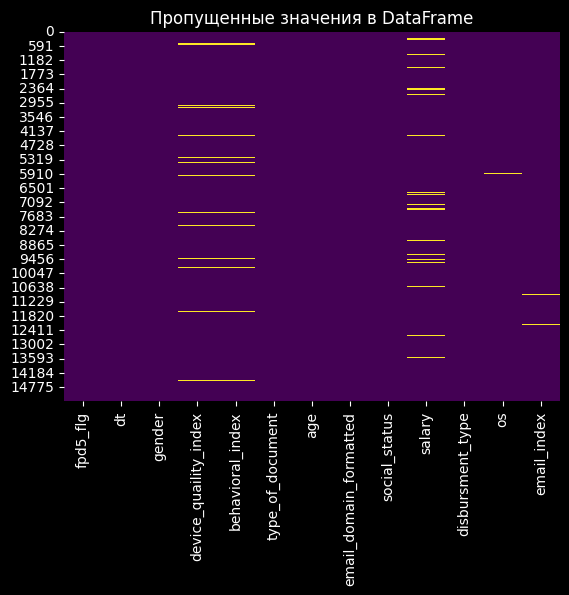

In [15]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в DataFrame')
plt.show()

In [16]:
df['dt'] = pd.to_datetime(df['dt'],format='%Y-%m-%d')

In [17]:
df['dt'].agg(['min','max'])

,dt
min,2020-12-09
max,2021-02-03


In [18]:
df

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.0,Bank,Android,0.0
1,0,2020-12-14,1,3.0,4.0,UMID,32,GMAIL.COM,Other,18000.0,E-wallet,Android,1.0
2,1,2021-01-26,0,0.0,3.0,SSS,41,YAHOO.COM,Private Company Employee,14000.0,Bank,Android,1.0
3,1,2020-12-10,1,0.0,5.0,TIN,28,GMAIL.COM,BPO Professionals,40000.0,E-wallet,Android,1.0
4,1,2021-01-17,0,3.0,3.0,UMID,31,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15358,0,2021-01-05,1,3.0,5.0,UMID,36,GMAIL.COM,Business Owner,25000.0,E-wallet,Android,6.0
15359,1,2021-01-23,1,0.0,3.0,Passport,32,GMAIL.COM,Self-Employed,25000.0,E-wallet,Android,1.0
15360,1,2021-02-01,1,1.0,5.0,UMID,29,GMAIL.COM,Private Company Employee,25000.0,E-wallet,Android,0.0
15361,0,2020-12-14,1,1.0,5.0,UMID,37,GMAIL.COM,Private Company Employee,25000.0,Bank,Android,6.0


In [19]:
df.groupby('os')['fpd5_flg'].agg(['count','mean']).sort_values('count',ascending=False)

,count,mean
os,,
Android,11499,0.284460
iOS,2947,0.230743
Windows,845,0.261538
macOS,40,0.150000
Linux,7,0.571429
Chrome OS,5,0.600000
OS X,4,0.500000


In [20]:
t = df.groupby('email_domain_formatted')['fpd5_flg'].agg(['count','mean']).sort_values('count',ascending=False)

In [21]:
t.sort_values('count',ascending=False).head(10)

,count,mean
email_domain_formatted,,
GMAIL.COM,12109,0.286564
YAHOO.COM,2626,0.228104
YAHOO.COM.PH,182,0.153846
DEPED.GOV.PH,100,0.230000
ICLOUD.COM,88,0.238636
YMAIL.COM,67,0.223881
ROCKETMAIL.COM,37,0.216216
HOTMAIL.COM,22,0.136364
OUTLOOK.COM,19,0.210526


In [22]:
df.groupby('behavioral_index',dropna=False)['fpd5_flg'].agg(['count','mean']).sort_values('count',ascending=False)

,count,mean
behavioral_index,,
4.0,4721,0.260538
3.0,4675,0.265027
5.0,4447,0.287385
6.0,730,0.324658
NaN,565,0.293805
2.0,202,0.198020
1.0,23,0.043478


<Axes: xlabel='behavioral_index'>

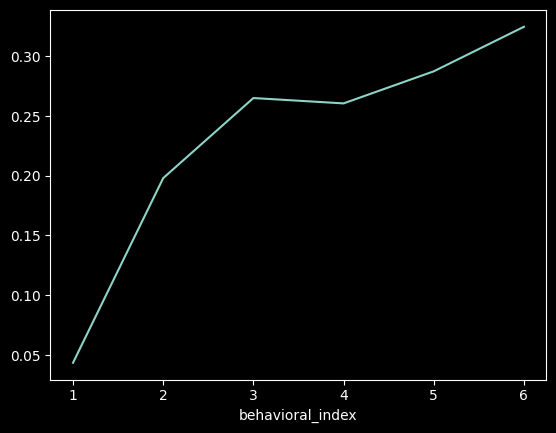

In [23]:
df.groupby('behavioral_index',dropna=False)['fpd5_flg'].mean().plot()

In [24]:
df.groupby('device_quaility_index',dropna=False)['fpd5_flg'].agg(['count','mean'])

,count,mean
device_quaility_index,,
0.0,1122,0.330660
1.0,2374,0.291070
2.0,2337,0.307659
3.0,7837,0.257496
4.0,1128,0.200355
NaN,565,0.293805


<Axes: xlabel='device_quaility_index'>

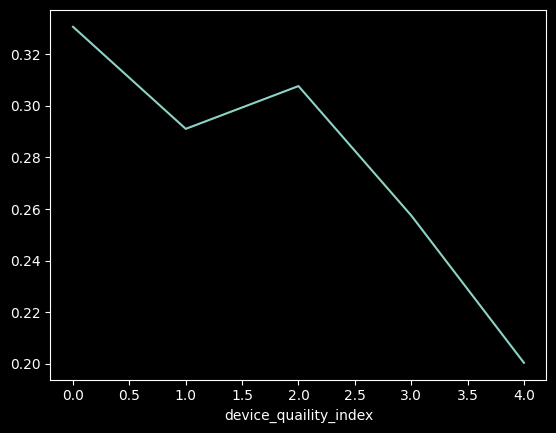

In [25]:
df.groupby('device_quaility_index',dropna=False)['fpd5_flg'].mean().plot()

In [26]:
df.groupby('type_of_document',dropna=False)['fpd5_flg'].agg(['count','mean']).sort_values('mean',ascending=False)

,count,mean
type_of_document,,
TIN,3057,0.307164
Driver license ID,3073,0.277904
Passport,1867,0.274772
UMID,5419,0.265178
SSS,1498,0.242991
PRC,449,0.187082


<Axes: xlabel='type_of_document'>

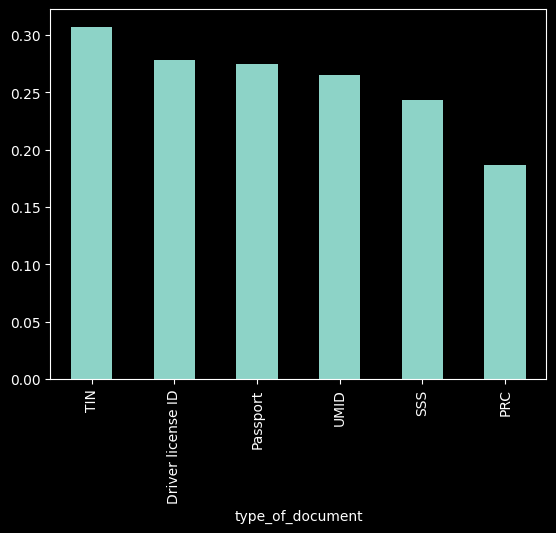

In [27]:
df.groupby('type_of_document',dropna=False)['fpd5_flg'].agg(['count','mean']).sort_values('mean',ascending=False)['mean'].plot(kind='bar')

<Axes: >

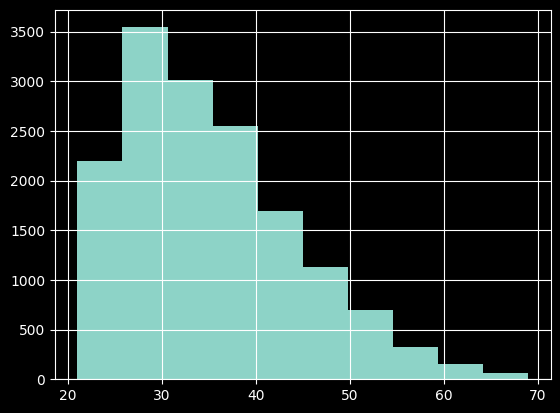

In [28]:
df['age'].hist()

In [29]:
df['age_bin'] = pd.qcut(df['age'],5)

In [30]:
df.groupby('age_bin',dropna=False)['fpd5_flg'].agg(['count','mean'])

/tmp/ipython-input-30-279365257.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_bin',dropna=False)['fpd5_flg'].agg(['count','mean'])


,count,mean
age_bin,,
"(20.999, 27.0]",3635,0.298212
"(27.0, 31.0]",2766,0.287419
"(31.0, 36.0]",2887,0.283685
"(36.0, 43.0]",3381,0.262053
"(43.0, 69.0]",2694,0.225316


/tmp/ipython-input-31-1209195686.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_bin',dropna=False)['fpd5_flg'].mean().plot()


<Axes: xlabel='age_bin'>

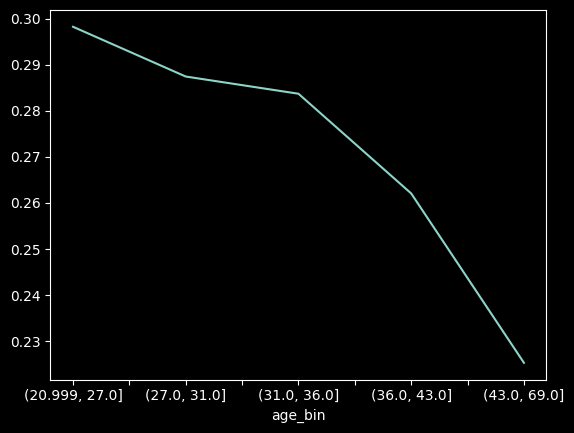

In [31]:
df.groupby('age_bin',dropna=False)['fpd5_flg'].mean().plot()

In [32]:
t = df.groupby('social_status',dropna=False)['fpd5_flg'].agg(['count','mean'])

In [33]:
t

,count,mean
social_status,,
BPO Professionals,2295,0.272767
Business Owner,1680,0.284524
Financial Services,247,0.182186
Freelance,777,0.280566
Government Employee,1061,0.258247
Other,1703,0.276571
Private Company Employee,3500,0.264286
"Professional Worker (Doctors, Engineers, Accountants, etc.)",642,0.194704
Retail Worker,402,0.298507


<Axes: xlabel='social_status'>

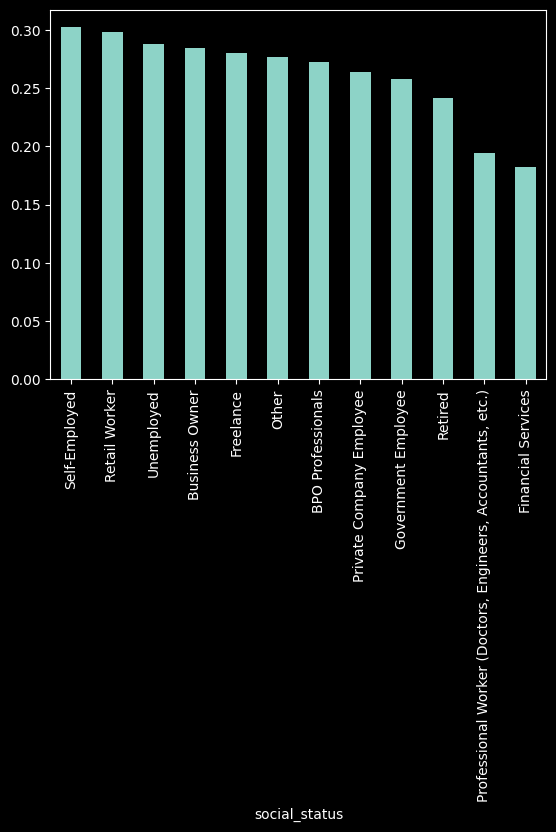

In [34]:
t.sort_values('mean',ascending=False)['mean'].plot(kind='bar')

<Axes: >

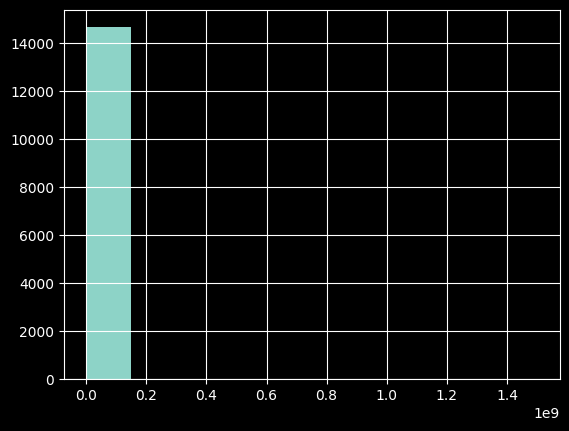

In [35]:
df['salary'].hist()

In [36]:
df['salary_bin'] = pd.qcut(df['salary'],5)

In [37]:
df

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index,age_bin,salary_bin
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.0,Bank,Android,0.0,"(20.999, 27.0]","(18000.0, 22000.0]"
1,0,2020-12-14,1,3.0,4.0,UMID,32,GMAIL.COM,Other,18000.0,E-wallet,Android,1.0,"(31.0, 36.0]","(14000.0, 18000.0]"
2,1,2021-01-26,0,0.0,3.0,SSS,41,YAHOO.COM,Private Company Employee,14000.0,Bank,Android,1.0,"(36.0, 43.0]","(-0.001, 14000.0]"
3,1,2020-12-10,1,0.0,5.0,TIN,28,GMAIL.COM,BPO Professionals,40000.0,E-wallet,Android,1.0,"(27.0, 31.0]","(30000.0, 1500020000.0]"
4,1,2021-01-17,0,3.0,3.0,UMID,31,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,0.0,"(27.0, 31.0]","(22000.0, 30000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15358,0,2021-01-05,1,3.0,5.0,UMID,36,GMAIL.COM,Business Owner,25000.0,E-wallet,Android,6.0,"(31.0, 36.0]","(22000.0, 30000.0]"
15359,1,2021-01-23,1,0.0,3.0,Passport,32,GMAIL.COM,Self-Employed,25000.0,E-wallet,Android,1.0,"(31.0, 36.0]","(22000.0, 30000.0]"
15360,1,2021-02-01,1,1.0,5.0,UMID,29,GMAIL.COM,Private Company Employee,25000.0,E-wallet,Android,0.0,"(27.0, 31.0]","(22000.0, 30000.0]"
15361,0,2020-12-14,1,1.0,5.0,UMID,37,GMAIL.COM,Private Company Employee,25000.0,Bank,Android,6.0,"(36.0, 43.0]","(22000.0, 30000.0]"


In [38]:
df.groupby('salary_bin',dropna=False)['fpd5_flg'].agg(['count','mean'])

/tmp/ipython-input-38-1775329345.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('salary_bin',dropna=False)['fpd5_flg'].agg(['count','mean'])


,count,mean
salary_bin,,
"(-0.001, 14000.0]",3026,0.298083
"(14000.0, 18000.0]",3036,0.291173
"(18000.0, 22000.0]",2820,0.275532
"(22000.0, 30000.0]",3906,0.273682
"(30000.0, 1500020000.0]",1861,0.193982
NaN,714,0.277311


In [39]:
df.groupby('disbursment_type',dropna=False)['fpd5_flg'].agg(['count','mean'])

,count,mean
disbursment_type,,
Bank,8918,0.216192
E-wallet,6445,0.351125


In [40]:
t = df.groupby('email_index',dropna=False)['fpd5_flg'].agg(['count','mean'])

In [41]:
t.sort_values('email_index',ascending=True)

,count,mean
email_index,,
0.0,4253,0.236539
1.0,8926,0.281201
2.0,129,0.217054
3.0,7,0.285714
4.0,232,0.331897
6.0,273,0.296703
8.0,1329,0.314522
10.0,176,0.318182
11.0,1,0.000000


<Axes: xlabel='email_index'>

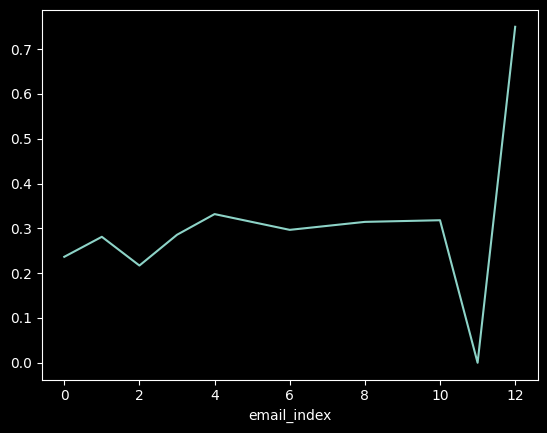

In [42]:
t.sort_values('email_index',ascending=True)['mean'].plot()

<Axes: xlabel='email_index'>

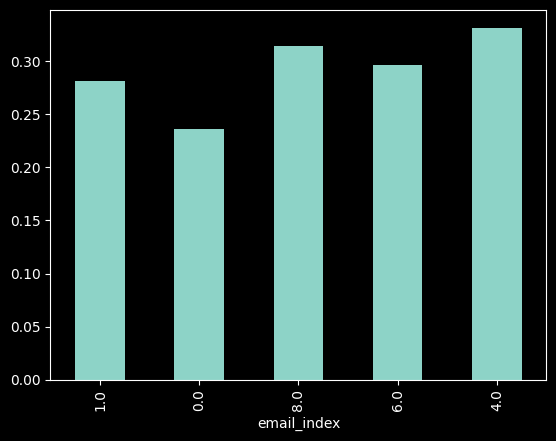

In [43]:
t.sort_values('count',ascending=False)['mean'].head(5).plot(kind='bar')

In [44]:
df.groupby('gender',dropna=False)['fpd5_flg'].agg(['count','mean'])

,count,mean
gender,,
0,5698,0.307125
1,9665,0.252561


## **Корреляция**

In [45]:
df = pd.read_excel('/content/fintech-testcase-default.xlsx')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  14649 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [47]:
corr_matrix = df.select_dtypes(include='number').corr() *100
#corr_matrix = df.corr()

In [48]:
corr_matrix

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
fpd5_flg,100.000000,-5.917635,-6.372088,3.619604,-5.732113,-0.516874,4.275326
gender,-5.917635,100.000000,-7.287549,-2.117343,-0.291395,0.632325,-0.017781
device_quaility_index,-6.372088,-7.287549,100.000000,-3.067515,-22.988691,-1.063868,-7.665583
behavioral_index,3.619604,-2.117343,-3.067515,100.000000,-1.861357,0.843864,3.629387
age,-5.732113,-0.291395,-22.988691,-1.861357,100.000000,0.568077,8.643478
salary,-0.516874,0.632325,-1.063868,0.843864,0.568077,100.000000,-0.199366
email_index,4.275326,-0.017781,-7.665583,3.629387,8.643478,-0.199366,100.000000


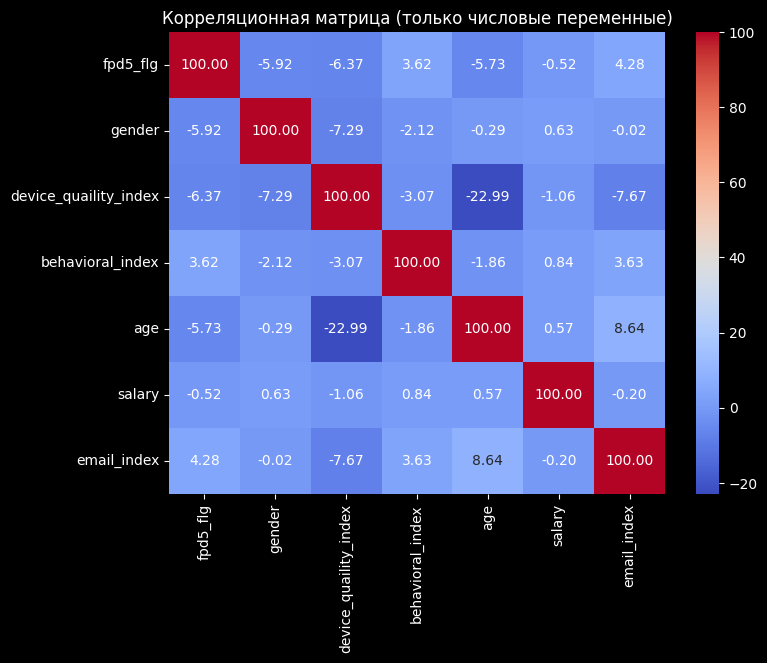

In [49]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица (только числовые переменные)')
plt.show()

In [50]:
!pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 10.2 MB/s eta 0:00:00


In [51]:
from phik import resources, report
from phik.report import plot_correlation_matrix

# Необходимо заменить текстовые категории на числа (если есть)
df_encoded = df.copy()
#df_encoded['gender'] = df_encoded['gender'].astype('category').cat.codes

# Расчёт phi-корреляций
corr_matrix = df_encoded.phik_matrix() * 100

# Вывод корреляционной матрицы
print(corr_matrix)

interval columns not set, guessing: ['fpd5_flg', 'gender', 'device_quaility_index', 'behavioral_index', 'age', 'salary', 'email_index']
                          fpd5_flg          dt      gender  \
fpd5_flg                100.000000   17.972348    9.172005   
dt                       17.972348  100.000000    5.766281   
gender                    9.172005    5.766281  100.000000   
device_quaility_index     5.717925   13.457028    6.593635   
behavioral_index          5.880576   36.183683    2.575338   
type_of_document          6.966590    0.851939   45.527746   
age                       7.097947   12.270602    5.716495   
email_domain_formatted    5.498474   11.567486    4.744607   
social_status             6.203961   15.312589   17.737284   
salary                    0.000000    0.000000    0.000000   
disbursment_type         23.212853   52.294708    6.430279   
os                        4.688225   13.788614    7.193624   
email_index               4.628387   12.925983    0.000000

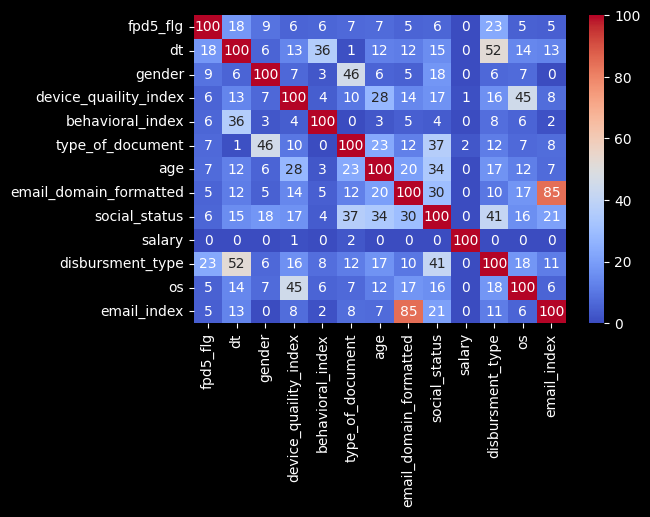

In [52]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".0f")
plt.show()

# **Model**

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
df.columns

Index(['fpd5_flg', 'dt', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index'],
      dtype='object')

In [55]:
X = ['gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index']

y = ['fpd5_flg']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df[X],
                                                    df[y],
                                                    test_size=0.3,
                                                    random_state=42)

In [57]:
X_train

,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
3132,0,1.0,5.0,UMID,24,GMAIL.COM,Other,20000.0,E-wallet,Android,0.0
7655,1,2.0,5.0,Passport,35,YAHOO.COM,Other,15000.0,E-wallet,Android,0.0
3520,1,3.0,4.0,Passport,37,ICLOUD.COM,Other,25000.0,E-wallet,iOS,8.0
14251,1,3.0,5.0,UMID,26,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",16000.0,Bank,iOS,1.0
2588,0,3.0,6.0,Driver license ID,50,GMAIL.COM,Business Owner,40000.0,E-wallet,Android,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5191,0,NaN,NaN,TIN,24,GMAIL.COM,Private Company Employee,24000.0,E-wallet,Android,1.0
13418,1,2.0,4.0,UMID,26,YAHOO.COM,BPO Professionals,24000.0,Bank,macOS,1.0
5390,0,3.0,4.0,Driver license ID,24,GMAIL.COM,Self-Employed,18000.0,E-wallet,Android,8.0
860,1,0.0,3.0,UMID,28,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,1.0


In [58]:
y_train

,fpd5_flg
3132,1
7655,0
3520,0
14251,0
2588,0
...,...
5191,0
13418,0
5390,0
860,0


In [59]:
features_num = X_train.select_dtypes(include='number').copy()

In [60]:
X_train

,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
3132,0,1.0,5.0,UMID,24,GMAIL.COM,Other,20000.0,E-wallet,Android,0.0
7655,1,2.0,5.0,Passport,35,YAHOO.COM,Other,15000.0,E-wallet,Android,0.0
3520,1,3.0,4.0,Passport,37,ICLOUD.COM,Other,25000.0,E-wallet,iOS,8.0
14251,1,3.0,5.0,UMID,26,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",16000.0,Bank,iOS,1.0
2588,0,3.0,6.0,Driver license ID,50,GMAIL.COM,Business Owner,40000.0,E-wallet,Android,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5191,0,NaN,NaN,TIN,24,GMAIL.COM,Private Company Employee,24000.0,E-wallet,Android,1.0
13418,1,2.0,4.0,UMID,26,YAHOO.COM,BPO Professionals,24000.0,Bank,macOS,1.0
5390,0,3.0,4.0,Driver license ID,24,GMAIL.COM,Self-Employed,18000.0,E-wallet,Android,8.0
860,1,0.0,3.0,UMID,28,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,1.0


In [61]:
features_num

,gender,device_quaility_index,behavioral_index,age,salary,email_index
3132,0,1.0,5.0,24,20000.0,0.0
7655,1,2.0,5.0,35,15000.0,0.0
3520,1,3.0,4.0,37,25000.0,8.0
14251,1,3.0,5.0,26,16000.0,1.0
2588,0,3.0,6.0,50,40000.0,1.0
...,...,...,...,...,...,...
5191,0,NaN,NaN,24,24000.0,1.0
13418,1,2.0,4.0,26,24000.0,1.0
5390,0,3.0,4.0,24,18000.0,8.0
860,1,0.0,3.0,28,25000.0,1.0


In [62]:
features_cat = X_train.select_dtypes(include='object').copy()

In [63]:
features_cat

,type_of_document,email_domain_formatted,social_status,disbursment_type,os
3132,UMID,GMAIL.COM,Other,E-wallet,Android
7655,Passport,YAHOO.COM,Other,E-wallet,Android
3520,Passport,ICLOUD.COM,Other,E-wallet,iOS
14251,UMID,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",Bank,iOS
2588,Driver license ID,GMAIL.COM,Business Owner,E-wallet,Android
...,...,...,...,...,...
5191,TIN,GMAIL.COM,Private Company Employee,E-wallet,Android
13418,UMID,YAHOO.COM,BPO Professionals,Bank,macOS
5390,Driver license ID,GMAIL.COM,Self-Employed,E-wallet,Android
860,UMID,GMAIL.COM,BPO Professionals,Bank,Android


In [64]:
features_num.isna().mean()

,0
gender,0.000000
device_quaility_index,0.036545
behavioral_index,0.036545
age,0.000000
salary,0.045285
email_index,0.002232


In [65]:
features_num.columns

Index(['gender', 'device_quaility_index', 'behavioral_index', 'age', 'salary',
       'email_index'],
      dtype='object')

# **Imputer**

In [66]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [67]:
most_freq_num_features = ['gender', 'device_quaility_index', 'behavioral_index','email_index']
median_num_features = [ 'age', 'salary']

In [68]:
median_num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median"))
    ])

In [69]:
most_freq_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent"))
    ])

In [70]:
fillna_pipe = ColumnTransformer([
    ("most_freq", most_freq_pipe, most_freq_num_features),
    ("median", median_num_pipe, median_num_features)
])

fillna_pipe = ColumnTransformer([
        ("most_freq", most_freq_pipe, most_freq_num_features),
        ("median", median_num_pipe, median_num_features)
    ])


In [71]:
fillna_pipe.fit_transform(X_train)

array([[0.0e+00, 1.0e+00, 5.0e+00, 0.0e+00, 2.4e+01, 2.0e+04],
       [1.0e+00, 2.0e+00, 5.0e+00, 0.0e+00, 3.5e+01, 1.5e+04],
       [1.0e+00, 3.0e+00, 4.0e+00, 8.0e+00, 3.7e+01, 2.5e+04],
       ...,
       [0.0e+00, 3.0e+00, 4.0e+00, 8.0e+00, 2.4e+01, 1.8e+04],
       [1.0e+00, 0.0e+00, 3.0e+00, 1.0e+00, 2.8e+01, 2.5e+04],
       [1.0e+00, 3.0e+00, 3.0e+00, 1.0e+00, 3.8e+01, 3.0e+03]])

In [72]:
t = pd.DataFrame(fillna_pipe.fit_transform(X_train),columns=most_freq_num_features+median_num_features)

In [73]:
t = t.set_index(X_train.index)

In [74]:
t.isna().mean()

,0
gender,0.0
device_quaility_index,0.0
behavioral_index,0.0
email_index,0.0
age,0.0
salary,0.0


In [75]:
t

,gender,device_quaility_index,behavioral_index,email_index,age,salary
3132,0.0,1.0,5.0,0.0,24.0,20000.0
7655,1.0,2.0,5.0,0.0,35.0,15000.0
3520,1.0,3.0,4.0,8.0,37.0,25000.0
14251,1.0,3.0,5.0,1.0,26.0,16000.0
2588,0.0,3.0,6.0,1.0,50.0,40000.0
...,...,...,...,...,...,...
5191,0.0,3.0,3.0,1.0,24.0,24000.0
13418,1.0,2.0,4.0,1.0,26.0,24000.0
5390,0.0,3.0,4.0,8.0,24.0,18000.0
860,1.0,0.0,3.0,1.0,28.0,25000.0


In [76]:
X_train['salary'].median()

20000.0

In [77]:
t[t.index.isin(X_train[X_train['salary'].isna()].index)]

,gender,device_quaility_index,behavioral_index,email_index,age,salary
7412,0.0,3.0,3.0,1.0,31.0,20000.0
8816,1.0,2.0,3.0,0.0,46.0,20000.0
5152,1.0,3.0,4.0,0.0,23.0,20000.0
14282,1.0,3.0,4.0,1.0,28.0,20000.0
11357,1.0,3.0,3.0,6.0,25.0,20000.0
...,...,...,...,...,...,...
2693,0.0,3.0,3.0,1.0,33.0,20000.0
13471,1.0,4.0,3.0,0.0,22.0,20000.0
8529,1.0,2.0,6.0,1.0,29.0,20000.0
8226,1.0,3.0,6.0,1.0,35.0,20000.0


In [78]:
X_train.isna().mean()

,0
gender,0.000000
device_quaility_index,0.036545
behavioral_index,0.036545
type_of_document,0.000000
age,0.000000
email_domain_formatted,0.000000
social_status,0.000000
salary,0.045285
disbursment_type,0.000000
os,0.001116


In [79]:
X_train['device_quaility_index'].median()

3.0

In [80]:
t[t.index.isin(X_train[X_train['device_quaility_index'].isna()].index)]

,gender,device_quaility_index,behavioral_index,email_index,age,salary
8885,1.0,3.0,3.0,10.0,31.0,7000.0
2666,1.0,3.0,3.0,0.0,33.0,15000.0
12092,0.0,3.0,3.0,1.0,34.0,21000.0
1896,0.0,3.0,3.0,1.0,24.0,20000.0
9002,1.0,3.0,3.0,1.0,36.0,15500.0
...,...,...,...,...,...,...
7916,1.0,3.0,3.0,1.0,24.0,9000.0
6863,0.0,3.0,3.0,1.0,37.0,15100.0
10233,1.0,3.0,3.0,1.0,28.0,1000.0
3005,1.0,3.0,3.0,1.0,48.0,20000.0


## **Feature adder**

In [81]:
df['salary_over_age'] = df['salary'] / df['age']

In [82]:
df['salary_over_age_bins'] = pd.qcut(df['salary_over_age'],5)

In [83]:
df.groupby('salary_over_age_bins')['fpd5_flg'].agg(['count','mean'])

/tmp/ipython-input-83-1067900146.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('salary_over_age_bins')['fpd5_flg'].agg(['count','mean'])


,count,mean
salary_over_age_bins,,
"(-0.001, 370.37]",2974,0.296234
"(370.37, 526.316]",2889,0.269297
"(526.316, 681.818]",2990,0.276923
"(681.818, 909.091]",2981,0.270044
"(909.091, 36585853.659]",2815,0.249023


/tmp/ipython-input-84-3056001087.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('salary_over_age_bins')['fpd5_flg'].mean().plot(rot=45)


<Axes: xlabel='salary_over_age_bins'>

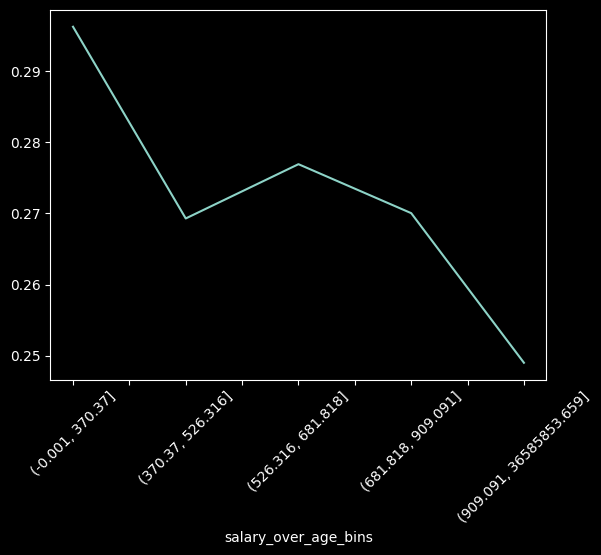

In [84]:
df.groupby('salary_over_age_bins')['fpd5_flg'].mean().plot(rot=45)

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
age_ix, salary_ix = 4, 5

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        salary_over_age = X[:, 5] / X[:, 4]


        return np.c_[X, salary_over_age]

## todo atribute adder with target encoding

In [86]:
attr_adder = CombinedAttributesAdder()

In [87]:
from sklearn.preprocessing import StandardScaler

In [88]:
num_pipeline = Pipeline([
        ('imputer', fillna_pipe),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [89]:
num_pipeline.fit_transform(X_train)

array([[-1.29632505, -1.30853215,  1.04638693, ..., -1.22414823,
        -0.00990637, -0.00928491],
       [ 0.77141146, -0.3701516 ,  1.04638693, ..., -0.01522725,
        -0.01025206, -0.01043227],
       [ 0.77141146,  0.56822895, -0.01270437, ...,  0.20457657,
        -0.00956068, -0.00973181],
       ...,
       [-1.29632505,  0.56822895, -0.01270437, ..., -1.22414823,
        -0.01004464, -0.00952113],
       [ 0.77141146, -2.24691271, -1.07179567, ..., -0.7845406 ,
        -0.00956068, -0.00911618],
       [ 0.77141146,  0.56822895, -1.07179567, ...,  0.31447847,
        -0.01108171, -0.01142333]])

In [90]:
t = pd.DataFrame(num_pipeline.fit_transform(X_train),
                 columns=most_freq_num_features+median_num_features + ['salary_over_age'])

In [91]:
t

,gender,device_quaility_index,behavioral_index,email_index,age,salary,salary_over_age
0,-1.296325,-1.308532,1.046387,-0.658811,-1.224148,-0.009906,-0.009285
1,0.771411,-0.370152,1.046387,-0.658811,-0.015227,-0.010252,-0.010432
2,0.771411,0.568229,-0.012704,2.686848,0.204577,-0.009561,-0.009732
3,0.771411,0.568229,1.046387,-0.240603,-1.004344,-0.010183,-0.009903
4,-1.296325,0.568229,2.105478,-0.240603,1.633301,-0.008524,-0.009379
...,...,...,...,...,...,...,...
10749,-1.296325,0.568229,-1.071796,-0.240603,-1.224148,-0.009630,-0.008812
10750,0.771411,-0.370152,-0.012704,-0.240603,-1.004344,-0.009630,-0.009031
10751,-1.296325,0.568229,-0.012704,2.686848,-1.224148,-0.010045,-0.009521
10752,0.771411,-2.246913,-1.071796,-0.240603,-0.784541,-0.009561,-0.009116


In [92]:
t = pd.DataFrame({'A':[1,0],'B':[0,1]})

In [93]:
t

,A,B
0,1,0
1,0,1


In [94]:
t.corr()

,A,B
A,1.0,-1.0
B,-1.0,1.0


# Categorical pipe

In [95]:
num_attribs = list(features_num.columns)

In [96]:
cat_attribs = list(features_cat.columns)

In [97]:
from sklearn.preprocessing import OneHotEncoder

In [98]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [99]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", ohe, cat_attribs)
    ])

In [100]:
t = pd.DataFrame(full_pipeline.fit_transform(X_train).toarray())

In [101]:
t

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,-1.296325,-1.308532,1.046387,-0.658811,-1.224148,-0.009906,-0.009285,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771411,-0.370152,1.046387,-0.658811,-0.015227,-0.010252,-0.010432,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.771411,0.568229,-0.012704,2.686848,0.204577,-0.009561,-0.009732,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.771411,0.568229,1.046387,-0.240603,-1.004344,-0.010183,-0.009903,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.296325,0.568229,2.105478,-0.240603,1.633301,-0.008524,-0.009379,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,-1.296325,0.568229,-1.071796,-0.240603,-1.224148,-0.009630,-0.008812,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10750,0.771411,-0.370152,-0.012704,-0.240603,-1.004344,-0.009630,-0.009031,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10751,-1.296325,0.568229,-0.012704,2.686848,-1.224148,-0.010045,-0.009521,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10752,0.771411,-2.246913,-1.071796,-0.240603,-0.784541,-0.009561,-0.009116,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
cat_features_names = list(full_pipeline.transformers_[1][1].get_feature_names_out())

In [103]:
cat_features_names

['type_of_document_Driver license ID',
 'type_of_document_PRC',
 'type_of_document_Passport',
 'type_of_document_SSS',
 'type_of_document_TIN',
 'type_of_document_UMID',
 'email_domain_formatted_ABS-CBN.COM',
 'email_domain_formatted_ABSOLUTELYCANDO.COM',
 'email_domain_formatted_AMSAMOA.EDU',
 'email_domain_formatted_AOL.COM',
 'email_domain_formatted_BOLTONINTERNATIONAL.COM',
 'email_domain_formatted_BULSU.EDU.PH',
 'email_domain_formatted_BURGANDRILLING.COM',
 'email_domain_formatted_CAREMIN.COM',
 'email_domain_formatted_CIIF.PH',
 'email_domain_formatted_CPSCTECH.ORG',
 'email_domain_formatted_DAVIESPAINTS.COM.PH',
 'email_domain_formatted_DEPED.GOV.PH',
 'email_domain_formatted_DEPEDQC.PH',
 'email_domain_formatted_DEXCOM.COM',
 'email_domain_formatted_DLSU.EDU.PH',
 'email_domain_formatted_EMAIL.COM',
 'email_domain_formatted_EMAIL.COM.PH',
 'email_domain_formatted_EMAIL.PH',
 'email_domain_formatted_EXELCIUSPH.COM',
 'email_domain_formatted_FRONTIER.COM',
 'email_domain_formatt

In [104]:
full_pipeline.transformers_[1][1]

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [105]:
t.columns = most_freq_num_features+median_num_features + ['salary_over_age'] + cat_features_names

In [106]:
t

,gender,device_quaility_index,behavioral_index,email_index,age,salary,salary_over_age,type_of_document_Driver license ID,type_of_document_PRC,type_of_document_Passport,...,disbursment_type_Bank,disbursment_type_E-wallet,os_Android,os_Chrome OS,os_Linux,os_OS X,os_Windows,os_iOS,os_macOS,os_nan
0,-1.296325,-1.308532,1.046387,-0.658811,-1.224148,-0.009906,-0.009285,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771411,-0.370152,1.046387,-0.658811,-0.015227,-0.010252,-0.010432,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.771411,0.568229,-0.012704,2.686848,0.204577,-0.009561,-0.009732,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.771411,0.568229,1.046387,-0.240603,-1.004344,-0.010183,-0.009903,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.296325,0.568229,2.105478,-0.240603,1.633301,-0.008524,-0.009379,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,-1.296325,0.568229,-1.071796,-0.240603,-1.224148,-0.009630,-0.008812,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10750,0.771411,-0.370152,-0.012704,-0.240603,-1.004344,-0.009630,-0.009031,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10751,-1.296325,0.568229,-0.012704,2.686848,-1.224148,-0.010045,-0.009521,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10752,0.771411,-2.246913,-1.071796,-0.240603,-0.784541,-0.009561,-0.009116,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
features_cat.isna().mean()

,0
type_of_document,0.000000
email_domain_formatted,0.000000
social_status,0.000000
disbursment_type,0.000000
os,0.001116


In [108]:
full_pipeline.transform(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 55283 stored elements and shape (4609, 105)>

# **Full Pipeline**

In [109]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [110]:
most_freq_num_features = ['gender', 'device_quaility_index',
                  'behavioral_index', 'email_index']

In [111]:
median_num_features = ['age', 'salary']

In [112]:
median_num_pipe = Pipeline([
          ('imputer', SimpleImputer(strategy="median"))])

In [113]:
most_freq_pipe = Pipeline([
          ('imputer', SimpleImputer(strategy="most_frequent"))])

In [114]:
fillna_pipe = ColumnTransformer([
        ("most_freq", most_freq_pipe, most_freq_num_features),
        ("median", median_num_pipe, median_num_features),
    ])

In [115]:
# column index
age_ix, salary_ix = 4, 5

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        salary_over_age = X[:, 5] / X[:, 4]


        return np.c_[X, salary_over_age]

## todo atribute adder with target encoding

In [116]:
attr_adder = CombinedAttributesAdder()

In [117]:
num_pipeline = Pipeline([
        ('imputer', fillna_pipe),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

In [118]:
num_attribs = ['gender',
 'device_quaility_index',
 'behavioral_index',
 'age',
 'salary',
 'email_index']

In [119]:
cat_attribs = ['type_of_document',
 'email_domain_formatted',
 'social_status',
 'disbursment_type',
 'os']

In [120]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs)
        ])

In [121]:
t = pd.DataFrame(full_pipeline.fit_transform(X_train).toarray())

In [122]:
cat_features_names = list(full_pipeline.transformers_[1][1].get_feature_names_out())

In [123]:
t.columns = most_freq_num_features+median_num_features + \
            ['salary_over_age'] + cat_features_names

In [124]:
t

,gender,device_quaility_index,behavioral_index,email_index,age,salary,salary_over_age,type_of_document_Driver license ID,type_of_document_PRC,type_of_document_Passport,...,disbursment_type_Bank,disbursment_type_E-wallet,os_Android,os_Chrome OS,os_Linux,os_OS X,os_Windows,os_iOS,os_macOS,os_nan
0,-1.296325,-1.308532,1.046387,-0.658811,-1.224148,-0.009906,-0.009285,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771411,-0.370152,1.046387,-0.658811,-0.015227,-0.010252,-0.010432,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.771411,0.568229,-0.012704,2.686848,0.204577,-0.009561,-0.009732,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.771411,0.568229,1.046387,-0.240603,-1.004344,-0.010183,-0.009903,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.296325,0.568229,2.105478,-0.240603,1.633301,-0.008524,-0.009379,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,-1.296325,0.568229,-1.071796,-0.240603,-1.224148,-0.009630,-0.008812,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10750,0.771411,-0.370152,-0.012704,-0.240603,-1.004344,-0.009630,-0.009031,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10751,-1.296325,0.568229,-0.012704,2.686848,-1.224148,-0.010045,-0.009521,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10752,0.771411,-2.246913,-1.071796,-0.240603,-0.784541,-0.009561,-0.009116,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Modeling**

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier

In [126]:
X_train_prep = pd.DataFrame(full_pipeline.fit_transform(X_train).toarray())

In [127]:
cat_features_names = list(full_pipeline.transformers_[1][1].get_feature_names_out())

In [128]:
X_train_prep.columns = most_freq_num_features+median_num_features + \
            ['salary_over_age'] + cat_features_names

In [129]:
log_reg = LogisticRegression(max_iter=10000)

In [130]:
tree_reg = DecisionTreeClassifier(random_state=42)

In [131]:
X_train_prep.shape

(10754, 105)

In [132]:
scores = cross_val_score(log_reg, X_train_prep, y_train,
                         scoring='roc_auc', cv=5)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [133]:
scores

array([0.60616302, 0.62973005, 0.64194025, 0.62836729, 0.61793692])

In [134]:
gb = GradientBoostingClassifier()

In [135]:
scores = cross_val_score(gb, X_train_prep, y_train['fpd5_flg'].values,
                         scoring='roc_auc', cv=5)

In [136]:
scores

array([0.59998253, 0.63592254, 0.62391709, 0.63471176, 0.6203485 ])

# **Catboost**

In [137]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [138]:
from catboost import CatBoostClassifier

In [139]:
X_train

,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
3132,0,1.0,5.0,UMID,24,GMAIL.COM,Other,20000.0,E-wallet,Android,0.0
7655,1,2.0,5.0,Passport,35,YAHOO.COM,Other,15000.0,E-wallet,Android,0.0
3520,1,3.0,4.0,Passport,37,ICLOUD.COM,Other,25000.0,E-wallet,iOS,8.0
14251,1,3.0,5.0,UMID,26,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",16000.0,Bank,iOS,1.0
2588,0,3.0,6.0,Driver license ID,50,GMAIL.COM,Business Owner,40000.0,E-wallet,Android,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5191,0,NaN,NaN,TIN,24,GMAIL.COM,Private Company Employee,24000.0,E-wallet,Android,1.0
13418,1,2.0,4.0,UMID,26,YAHOO.COM,BPO Professionals,24000.0,Bank,macOS,1.0
5390,0,3.0,4.0,Driver license ID,24,GMAIL.COM,Self-Employed,18000.0,E-wallet,Android,8.0
860,1,0.0,3.0,UMID,28,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,1.0


In [140]:
cat_attribs

['type_of_document',
 'email_domain_formatted',
 'social_status',
 'disbursment_type',
 'os']

In [141]:
X_train_nona = X_train.dropna().copy()

In [142]:
y_train_nona = y_train[y_train.index.isin(X_train_nona.index)].copy()

In [143]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train_nona,
                                                    y_train_nona,
                                                    test_size=0.3,
                                                    random_state=42)

In [144]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_attribs,
          'verbose': 20,
          'random_seed': 42,
          'early_stopping_rounds': 200,
          "auto_class_weights":"Balanced"
         }

In [145]:
cb = CatBoostClassifier(**params)

In [146]:
cb.fit(X_train_,y_train_,eval_set=(X_val,y_val))

Learning rate set to 0.05107
0:	test: 0.6216208	best: 0.6216208 (0)	total: 88.2ms	remaining: 1m 28s
20:	test: 0.6289001	best: 0.6289001 (20)	total: 487ms	remaining: 22.7s
40:	test: 0.6288918	best: 0.6290820 (21)	total: 926ms	remaining: 21.7s
60:	test: 0.6271955	best: 0.6290820 (21)	total: 1.44s	remaining: 22.2s
80:	test: 0.6282337	best: 0.6290820 (21)	total: 1.94s	remaining: 22s
100:	test: 0.6266352	best: 0.6290820 (21)	total: 2.55s	remaining: 22.7s
120:	test: 0.6257065	best: 0.6290820 (21)	total: 3.28s	remaining: 23.9s
140:	test: 0.6278550	best: 0.6290820 (21)	total: 4.12s	remaining: 25.1s
160:	test: 0.6280736	best: 0.6290820 (21)	total: 4.98s	remaining: 25.9s
180:	test: 0.6278516	best: 0.6290820 (21)	total: 5.91s	remaining: 26.8s
200:	test: 0.6281188	best: 0.6290820 (21)	total: 6.96s	remaining: 27.7s
220:	test: 0.6262826	best: 0.6290820 (21)	total: 7.74s	remaining: 27.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6290820427
bestIteration = 21

Shrink model t

# **OHE drop first**

In [147]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(drop='first'), cat_attribs),
    ])

In [148]:
X_train_prep = pd.DataFrame(full_pipeline.fit_transform(X_train).toarray())

In [149]:
cat_features_names = list(full_pipeline.transformers_[1][1].get_feature_names_out())

In [150]:
X_train_prep.columns = most_freq_num_features+median_num_features + \
            ['salary_over_age'] + cat_features_names

In [151]:
X_train_prep.shape

(10754, 100)

In [152]:
log_reg = LogisticRegression(max_iter=10000)

In [153]:
scores = cross_val_score(log_reg, X_train_prep, y_train['fpd5_flg'].values,
                         scoring=make_scorer(roc_auc_score), cv=5)

In [154]:
scores

array([0.5050447 , 0.50129679, 0.50280234, 0.50975273, 0.49885298])

In [155]:
cb = CatBoostClassifier(iterations=500,auto_class_weights="Balanced",verbose=0)

In [156]:
scores = cross_val_score(cb, X_train_prep, y_train['fpd5_flg'].values,
                         scoring=make_scorer(roc_auc_score), cv=5,n_jobs=-1)

In [157]:
scores

array([0.57719815, 0.59819727, 0.5727554 , 0.57915286, 0.58781535])

## **Pipeline debug**

In [158]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 20,
          'random_seed': 42,
          'early_stopping_rounds': 200
         }

In [159]:
cb = CatBoostClassifier(**params)

In [160]:
cb.fit(X_train_[num_attribs],y_train_,eval_set=(X_val[num_attribs],y_val))

Learning rate set to 0.05107
0:	test: 0.5228330	best: 0.5228330 (0)	total: 2.69ms	remaining: 2.68s
20:	test: 0.5651951	best: 0.5652000 (18)	total: 57.1ms	remaining: 2.66s
40:	test: 0.5704483	best: 0.5704483 (40)	total: 117ms	remaining: 2.73s
60:	test: 0.5743135	best: 0.5743135 (60)	total: 180ms	remaining: 2.77s
80:	test: 0.5755617	best: 0.5767300 (69)	total: 242ms	remaining: 2.75s
100:	test: 0.5739320	best: 0.5767300 (69)	total: 304ms	remaining: 2.71s
120:	test: 0.5738201	best: 0.5767300 (69)	total: 360ms	remaining: 2.62s
140:	test: 0.5751861	best: 0.5767300 (69)	total: 444ms	remaining: 2.7s
160:	test: 0.5734763	best: 0.5767300 (69)	total: 503ms	remaining: 2.62s
180:	test: 0.5719994	best: 0.5767300 (69)	total: 563ms	remaining: 2.55s
200:	test: 0.5723855	best: 0.5767300 (69)	total: 622ms	remaining: 2.47s
220:	test: 0.5727733	best: 0.5767300 (69)	total: 682ms	remaining: 2.4s
240:	test: 0.5731228	best: 0.5767300 (69)	total: 739ms	remaining: 2.33s
260:	test: 0.5739883	best: 0.5767300 (69)	

## **Pipeline debug**

In [161]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 20,
          'random_seed': 42,
          'early_stopping_rounds': 200
         }

In [162]:
cb = CatBoostClassifier(**params)

In [163]:
cb.fit(X_train_[num_attribs],y_train_,eval_set=(X_val[num_attribs],y_val))

Learning rate set to 0.05107
0:	test: 0.5228330	best: 0.5228330 (0)	total: 2.65ms	remaining: 2.65s
20:	test: 0.5651951	best: 0.5652000 (18)	total: 54.4ms	remaining: 2.54s
40:	test: 0.5704483	best: 0.5704483 (40)	total: 109ms	remaining: 2.56s
60:	test: 0.5743135	best: 0.5743135 (60)	total: 169ms	remaining: 2.6s
80:	test: 0.5755617	best: 0.5767300 (69)	total: 230ms	remaining: 2.62s
100:	test: 0.5739320	best: 0.5767300 (69)	total: 285ms	remaining: 2.54s
120:	test: 0.5738201	best: 0.5767300 (69)	total: 342ms	remaining: 2.49s
140:	test: 0.5751861	best: 0.5767300 (69)	total: 398ms	remaining: 2.42s
160:	test: 0.5734763	best: 0.5767300 (69)	total: 457ms	remaining: 2.38s
180:	test: 0.5719994	best: 0.5767300 (69)	total: 524ms	remaining: 2.37s
200:	test: 0.5723855	best: 0.5767300 (69)	total: 583ms	remaining: 2.32s
220:	test: 0.5727733	best: 0.5767300 (69)	total: 642ms	remaining: 2.26s
240:	test: 0.5731228	best: 0.5767300 (69)	total: 701ms	remaining: 2.21s
260:	test: 0.5739883	best: 0.5767300 (69)

In [164]:
X_train_num_trans = num_pipeline.fit_transform(X_train)

In [165]:
log_reg = LogisticRegression(class_weight='balanced')

In [166]:
from sklearn.metrics import f1_score

In [167]:
scores = cross_val_score(log_reg, X_train_num_trans, y_train['fpd5_flg'].values,
                         scoring=make_scorer(roc_auc_score), cv=5)

In [168]:
scores

array([0.55519697, 0.5569162 , 0.54230993, 0.57601942, 0.55923827])

In [169]:
y_train['fpd5_flg'].values.mean()

np.float64(0.2717128510321741)

In [170]:
X_train_num_trans = num_pipeline.fit_transform(X_train)

In [171]:
log_reg = LogisticRegression(class_weight='balanced')

In [172]:
from sklearn.metrics import f1_score

In [173]:
scores = cross_val_score(log_reg, X_train_num_trans, y_train['fpd5_flg'].values,
                         scoring=make_scorer(roc_auc_score), cv=5)

In [174]:
scores

array([0.55519697, 0.5569162 , 0.54230993, 0.57601942, 0.55923827])

In [175]:
y_train['fpd5_flg'].values.mean()

np.float64(0.2717128510321741)

# **Delete outliers**

<Axes: >

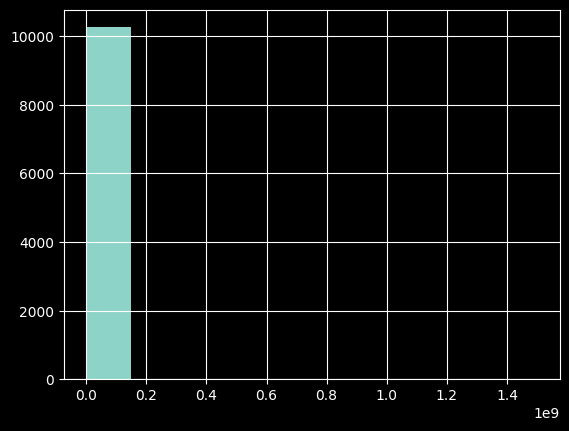

In [176]:
X_train['salary'].hist()

In [177]:
X_train_nona

,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
3132,0,1.0,5.0,UMID,24,GMAIL.COM,Other,20000.0,E-wallet,Android,0.0
7655,1,2.0,5.0,Passport,35,YAHOO.COM,Other,15000.0,E-wallet,Android,0.0
3520,1,3.0,4.0,Passport,37,ICLOUD.COM,Other,25000.0,E-wallet,iOS,8.0
14251,1,3.0,5.0,UMID,26,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",16000.0,Bank,iOS,1.0
2588,0,3.0,6.0,Driver license ID,50,GMAIL.COM,Business Owner,40000.0,E-wallet,Android,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11964,0,3.0,3.0,Passport,51,GMAIL.COM,Other,45000.0,Bank,iOS,1.0
13418,1,2.0,4.0,UMID,26,YAHOO.COM,BPO Professionals,24000.0,Bank,macOS,1.0
5390,0,3.0,4.0,Driver license ID,24,GMAIL.COM,Self-Employed,18000.0,E-wallet,Android,8.0
860,1,0.0,3.0,UMID,28,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,1.0


In [178]:
X_train_nona_noout = X_train_nona[X_train_nona['salary'] <= X_train_nona['salary'].quantile(0.99)].copy()

In [179]:
y_train_nona_noout = y_train_nona[y_train_nona.index.isin(X_train_nona_noout.index)].copy()

In [180]:
X_train_nona_noout

,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
3132,0,1.0,5.0,UMID,24,GMAIL.COM,Other,20000.0,E-wallet,Android,0.0
7655,1,2.0,5.0,Passport,35,YAHOO.COM,Other,15000.0,E-wallet,Android,0.0
3520,1,3.0,4.0,Passport,37,ICLOUD.COM,Other,25000.0,E-wallet,iOS,8.0
14251,1,3.0,5.0,UMID,26,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",16000.0,Bank,iOS,1.0
2588,0,3.0,6.0,Driver license ID,50,GMAIL.COM,Business Owner,40000.0,E-wallet,Android,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11964,0,3.0,3.0,Passport,51,GMAIL.COM,Other,45000.0,Bank,iOS,1.0
13418,1,2.0,4.0,UMID,26,YAHOO.COM,BPO Professionals,24000.0,Bank,macOS,1.0
5390,0,3.0,4.0,Driver license ID,24,GMAIL.COM,Self-Employed,18000.0,E-wallet,Android,8.0
860,1,0.0,3.0,UMID,28,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,1.0


In [181]:
ohe = OneHotEncoder(drop='first')

In [182]:
scaler = StandardScaler()

In [183]:
X_train_num_manual = pd.DataFrame(scaler.fit_transform(X_train_nona_noout[num_attribs]))

In [184]:
X_train_cat_manual = pd.DataFrame(ohe.fit_transform(X_train_nona_noout[cat_attribs]).toarray())

In [185]:
X_train_manual_prep = pd.concat([X_train_num_manual,X_train_cat_manual],axis=1)

In [186]:
X_train_manual_prep.shape

(9767, 91)

In [187]:
log_reg = LogisticRegression(max_iter=1000)

In [188]:
scores = cross_val_score(log_reg, X_train_manual_prep, y_train_nona_noout['fpd5_flg'].values,
                         scoring=make_scorer(roc_auc_score), cv=5)

In [189]:
scores

array([0.50482747, 0.49989161, 0.50317604, 0.50918973, 0.49930868])

In [190]:
log_reg = LogisticRegression()

In [191]:
scores = cross_val_score(log_reg, X_train_num_manual, y_train_nona_noout['fpd5_flg'].values,
                         scoring=make_scorer(roc_auc_score), cv=5)

In [192]:
scores

array([0.49964838, 0.5       , 0.5       , 0.5       , 0.5       ])

In [193]:
cb = CatBoostClassifier(iterations=100,verbose=0)

In [194]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [195]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [196]:
scores = cross_val_score(log_reg, X_train_nona_noout[num_attribs], y_train_nona_noout['fpd5_flg'].values,
                         scoring='roc_auc', cv=cv)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to

In [197]:
scores

array([0.5728324 , 0.56128454, 0.55208432, 0.5664134 , 0.54790722,
       0.57216617, 0.58824012, 0.56490257, 0.59429982, 0.59585224,
       0.54995611, 0.59883623, 0.56491968, 0.55930702, 0.54325423,
       0.56969163, 0.59798758, 0.61947474, 0.58474378, 0.56841281,
       0.60447797, 0.57103994, 0.60070271, 0.59986728, 0.57372863,
       0.58013441, 0.56372736, 0.53656147, 0.55393679, 0.55346177])

In [198]:
log_reg = LogisticRegression(max_iter=10000)

In [199]:
scores = cross_val_score(log_reg, X_train_manual_prep, y_train_nona_noout['fpd5_flg'].values,
                         scoring='roc_auc', cv=cv)

In [200]:
scores

array([0.64351808, 0.61974557, 0.57859839, 0.61114812, 0.60504637,
       0.64771105, 0.61175618, 0.63487769, 0.6292758 , 0.63981636,
       0.60722481, 0.66602688, 0.58437761, 0.59771528, 0.61747724,
       0.61205228, 0.67036262, 0.65222916, 0.62251944, 0.60617254,
       0.65573744, 0.62115997, 0.65635079, 0.6164594 , 0.60543236,
       0.63710965, 0.63103434, 0.59355607, 0.6147122 , 0.60159754])

In [201]:
scores.mean()

np.float64(0.6230267083131078)

In [202]:
scores = cross_val_score(log_reg, X_train_prep, y_train['fpd5_flg'].values,
                         scoring='roc_auc', cv=cv)

In [203]:
scores.mean()

np.float64(0.6248393816753126)

In [204]:
log_reg = LogisticRegression(max_iter=10000,class_weight='balanced')

In [205]:
scores = cross_val_score(log_reg, X_train_prep, y_train['fpd5_flg'].values,
                         scoring='roc_auc', cv=cv)

In [206]:
scores.mean()

np.float64(0.625083917051498)

# **Cross validation with two metrics**

In [207]:
X_train_prep = pd.DataFrame(full_pipeline.fit_transform(X_train).toarray())

In [208]:
cat_features_names = list(full_pipeline.transformers_[1][1].get_feature_names_out())

In [209]:
X_train_prep.columns = most_freq_num_features+median_num_features + \
            ['salary_over_age'] + cat_features_names

In [210]:
log_reg = LogisticRegression(max_iter=10000)

In [211]:
tree_reg = DecisionTreeClassifier(random_state=42)

In [212]:
from sklearn.model_selection import cross_validate

In [213]:
scoring = {'roc_auc': 'roc_auc',
           'average_precision': 'average_precision'}

In [214]:
scores = cross_validate(log_reg, X_train_prep, y_train['fpd5_flg'].values, scoring=scoring,
                         cv=cv, return_train_score=True)

In [215]:
scores['test_average_precision'].mean()

np.float64(0.36799599643326736)

In [216]:
scores['test_roc_auc'].mean()

np.float64(0.6248393816753126)

In [217]:
scores['test_average_precision'].mean()

np.float64(0.36799599643326736)

In [218]:
import matplotlib.pyplot as plt


plt.style.use('dark_background')

<Axes: >

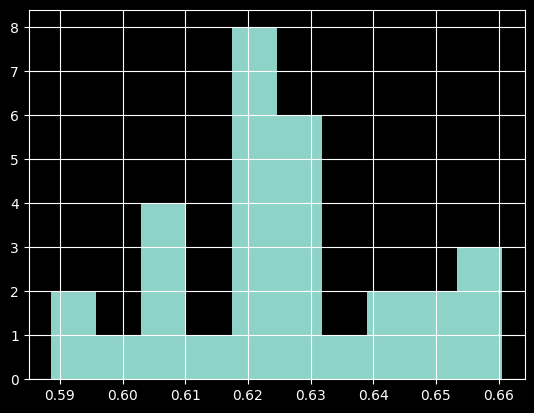

In [219]:
pd.Series(scores['test_roc_auc']).hist()

# **Target encoding**

In [223]:
df['type_of_document'].value_counts()

,count
type_of_document,
UMID,5419
Driver license ID,3073
TIN,3057
Passport,1867
SSS,1498
PRC,449


In [224]:
cat_dict = df.groupby('type_of_document')['fpd5_flg'].mean().to_dict()

In [225]:
cat_dict

{'Driver license ID': 0.27790432801822323,
 'PRC': 0.1870824053452116,
 'Passport': 0.2747723620782003,
 'SSS': 0.24299065420560748,
 'TIN': 0.3071638861629048,
 'UMID': 0.26517807713600294}

In [226]:
df['type_of_document'].map(cat_dict)

,type_of_document
0,0.265178
1,0.265178
2,0.242991
3,0.307164
4,0.265178
...,...
15358,0.265178
15359,0.274772
15360,0.265178
15361,0.265178


In [227]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.features_dict = {}
        self.mean_pd = None

    def fit(self, X, y=None):
        df = X.copy()
        df = df.fillna('na')
        cols = df.columns
        df['fpd5_flg'] = y
        self.mean_pd = df['fpd5_flg'].mean()

        for col in cols:
          self.features_dict[col] = df.groupby(col)['fpd5_flg'].mean().to_dict()

        return self

    def transform(self, X):
        X = X.fillna('na')
        for col, d in self.features_dict.items():
          X[col] = X[col].map(d)

        return X.fillna(self.mean_pd)

## todo atribute adder with target encoding

In [228]:
te = TargetEncoder()

In [229]:
te.fit(X_train[cat_attribs],y_train)

TargetEncoder()

In [230]:
te.transform(X_train[cat_attribs]).isna().mean()

,0
type_of_document,0.0
email_domain_formatted,0.0
social_status,0.0
disbursment_type,0.0
os,0.0


In [231]:
te.transform(X_test[cat_attribs]).isna().mean()

,0
type_of_document,0.0
email_domain_formatted,0.0
social_status,0.0
disbursment_type,0.0
os,0.0


In [232]:
log_reg = LogisticRegression(max_iter=10000)

In [233]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", TargetEncoder(), cat_attribs),
    ])

In [234]:
model_pipe = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', log_reg)]
)

In [235]:
model_pipe.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [236]:
model_pipe.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [237]:
scores = cross_validate(model_pipe, X_train, y_train['fpd5_flg'].values,
                        scoring=scoring,
                         cv=cv, return_train_score=True)

In [238]:
scores

{'fit_time': array([0.11983204, 0.08996201, 0.10360074, 0.09271049, 0.09247994,
        0.09450364, 0.128335  , 0.1353724 , 0.31007576, 0.29218006,
        0.27597976, 0.48860288, 0.19142914, 0.13042521, 0.17735195,
        0.23730659, 0.09198952, 0.08932042, 0.09113145, 0.09791207,
        0.09196758, 0.09100819, 0.08962989, 0.09430075, 0.09733486,
        0.09132528, 0.09495711, 0.09436607, 0.09003806, 0.08995342]),
 'score_time': array([0.02356005, 0.02054763, 0.02194619, 0.02251172, 0.02206755,
        0.02266002, 0.05875993, 0.02706146, 0.02618814, 0.04835248,
        0.05107474, 0.04979062, 0.03775263, 0.02374554, 0.04774404,
        0.022089  , 0.02157879, 0.02169299, 0.02177167, 0.02177143,
        0.02167106, 0.0225997 , 0.02748489, 0.02303696, 0.02361798,
        0.02175927, 0.02269363, 0.02210975, 0.02753854, 0.02202368]),
 'test_roc_auc': array([0.58947602, 0.62692061, 0.62660312, 0.65493081, 0.65566884,
        0.6207159 , 0.60769083, 0.61854651, 0.62022166, 0.62802883,
  

In [239]:
scores['test_roc_auc'].mean()

np.float64(0.6251992954024862)

In [240]:
scores['test_average_precision'].mean()

np.float64(0.3674898353492553)

# Target encoding + ohe

In [246]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat_te", TargetEncoder(), cat_attribs),
        ("cat_ohe", OneHotEncoder(handle_unknown='ignore'), cat_attribs)
    ])

In [247]:
model_pipe = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', log_reg)]
)

In [248]:
scores = cross_validate(model_pipe, X_train, y_train['fpd5_flg'].values,
                        scoring=scoring,
                         cv=cv, return_train_score=True)

In [249]:
scores['test_roc_auc'].mean()

np.float64(0.6251429086020167)

In [250]:
scores['test_average_precision'].mean()

np.float64(0.3679138707865323)

# Grid search

In [251]:
log_reg = LogisticRegression()

In [252]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat_te", TargetEncoder(), cat_attribs),
    ])

In [253]:
model_pipe = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', log_reg)]
)

In [254]:
scores = cross_validate(model_pipe, X_train, y_train['fpd5_flg'].values,
                        scoring=scoring,
                        cv=5, return_train_score=True)

In [255]:
scores['test_roc_auc'].mean()

np.float64(0.6245188028980377)

In [256]:
 param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'model__penalty': ['none', 'l2']}

In [257]:
from sklearn.model_selection import GridSearchCV

In [258]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [259]:
clf = GridSearchCV(model_pipe, param_grid,cv=5,scoring='roc_auc',n_jobs=-1)

In [260]:
clf.fit(X_train, y_train['fpd5_flg'].values)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 661, in fit
    self._final_estimator.fit(Xt, y, **la

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__C': [0.001, 0.01, ...], 'model__penalty': ['none', 'l2']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat_te', ...)]"


In [261]:
clf.best_params_

{'model__C': 1, 'model__penalty': 'l2'}